# Spatial salt-and-pepper demo

This notebook demonstrates how spatial autocorrelation in the truth plus noisy, pointwise features produces salt-and-pepper artifacts for pointwise classifiers, and how a simple neighborhood feature reduces them.

In [1]:
# Setup: imports, plotting backend, and warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GroupKFold
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-whitegrid')
import warnings
warnings.filterwarnings('ignore')
print('Libraries imported.')

Libraries imported.


### Features per point (brief)

- Baseline: 2 features per location: (1) noisy local signal, (2) independent noise  
- Spatial-corrected: 3 features per location: adds a local-mean/neighborhood summary

In [2]:
# Generate smooth field and labels
H, W = 160, 200
rng = np.random.default_rng(42)
raw = rng.standard_normal(size=(H, W))
smooth = gaussian_filter(raw, sigma=8.0)
smooth = (smooth - smooth.min()) / (smooth.max() - smooth.min())
labels = np.zeros((H, W), dtype=int)
labels[smooth > 0.65] = 2
labels[(smooth > 0.35) & (smooth <= 0.65)] = 1


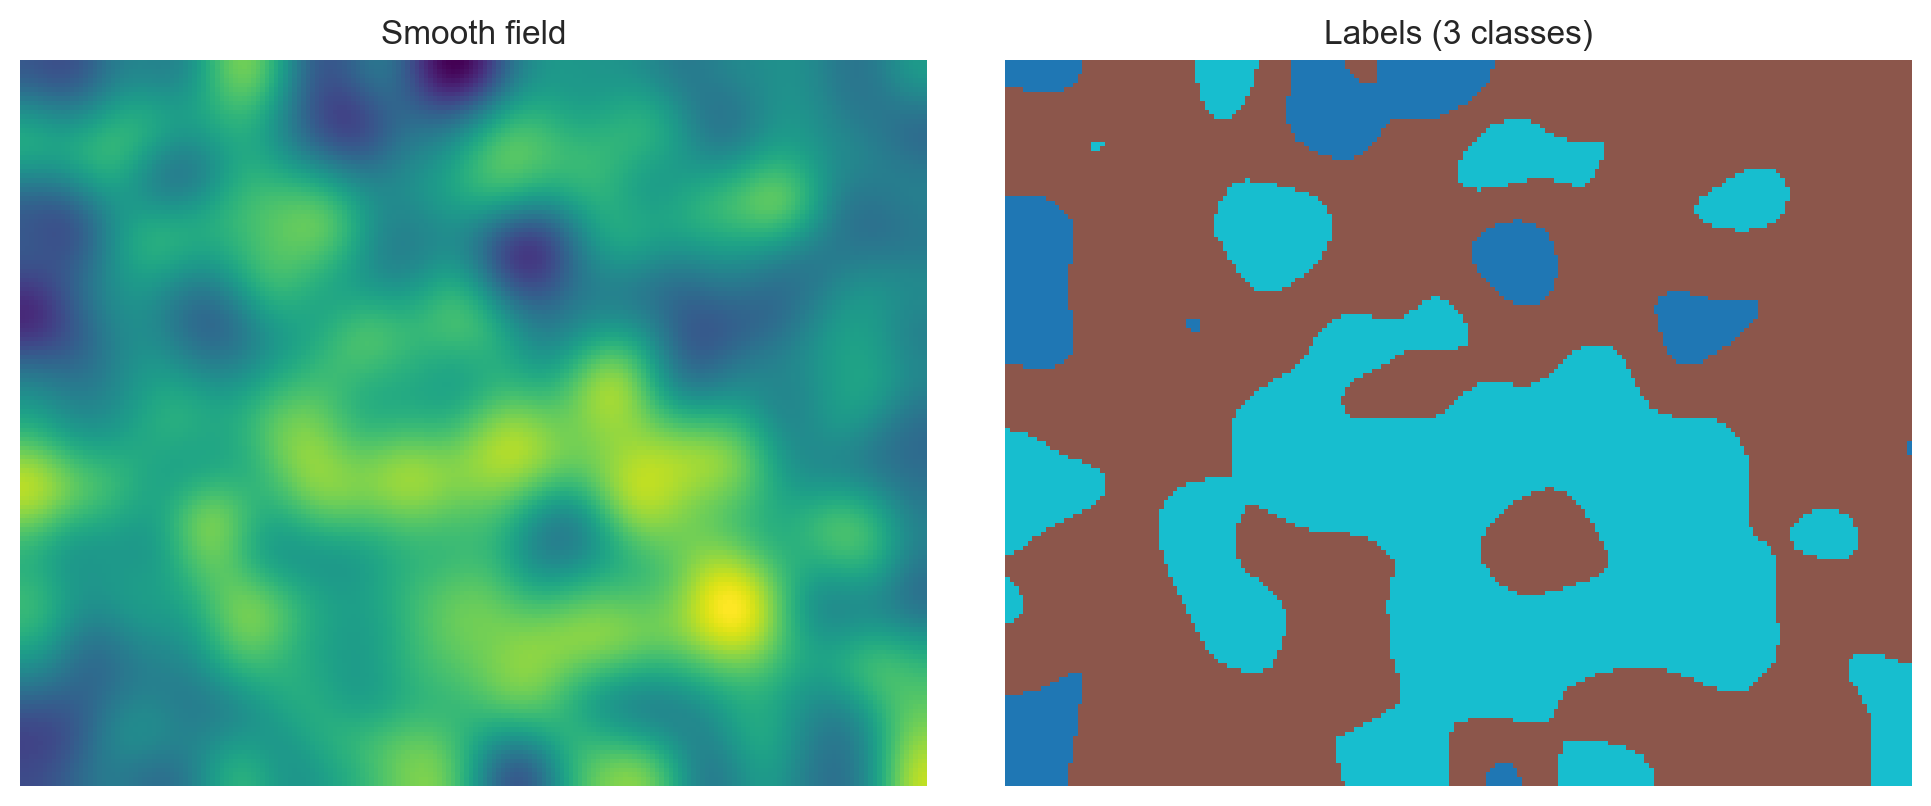

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].imshow(smooth, cmap='viridis'); ax[0].axis('off'); ax[0].set_title('Smooth field')
cm = plt.get_cmap('tab10')
ax[1].imshow(labels, cmap=cm, vmin=0, vmax=2); ax[1].axis('off'); ax[1].set_title('Labels (3 classes)')
plt.tight_layout(); plt.show()

In [4]:
# Baseline features and RF
feat_signal = smooth + 0.12 * rng.standard_normal(size=(H, W))
feat_noise  = 0.6 * rng.standard_normal(size=(H, W))
X_full = np.stack([feat_signal.ravel(), feat_noise.ravel()], axis=1)
y_full = labels.ravel()
n_train = int(0.12 * H * W)
all_idx = np.arange(H * W)
train_idx = rng.choice(all_idx, size=n_train, replace=False)
clf_base = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)
clf_base.fit(X_full[train_idx], y_full[train_idx])
pred_base_full = clf_base.predict(X_full).reshape(H, W)

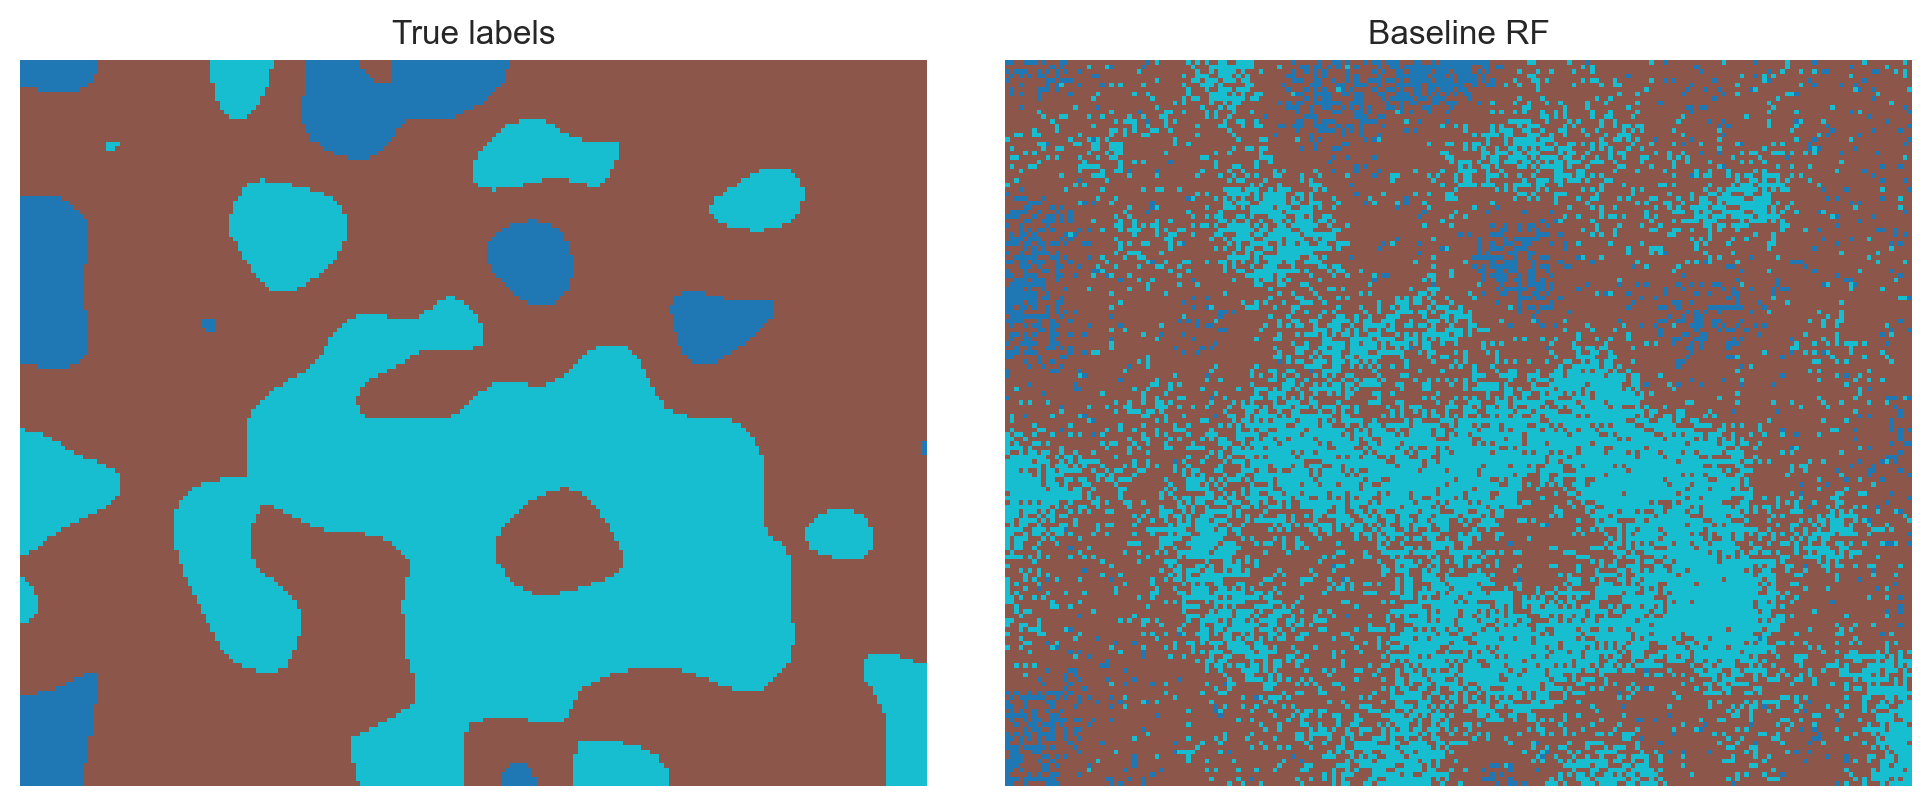

In [5]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].imshow(labels, cmap=cm, vmin=0, vmax=2); ax[0].axis('off'); ax[0].set_title('True labels')
ax[1].imshow(pred_base_full, cmap=cm, vmin=0, vmax=2); ax[1].axis('off'); ax[1].set_title('Baseline RF')
plt.tight_layout(); plt.show()

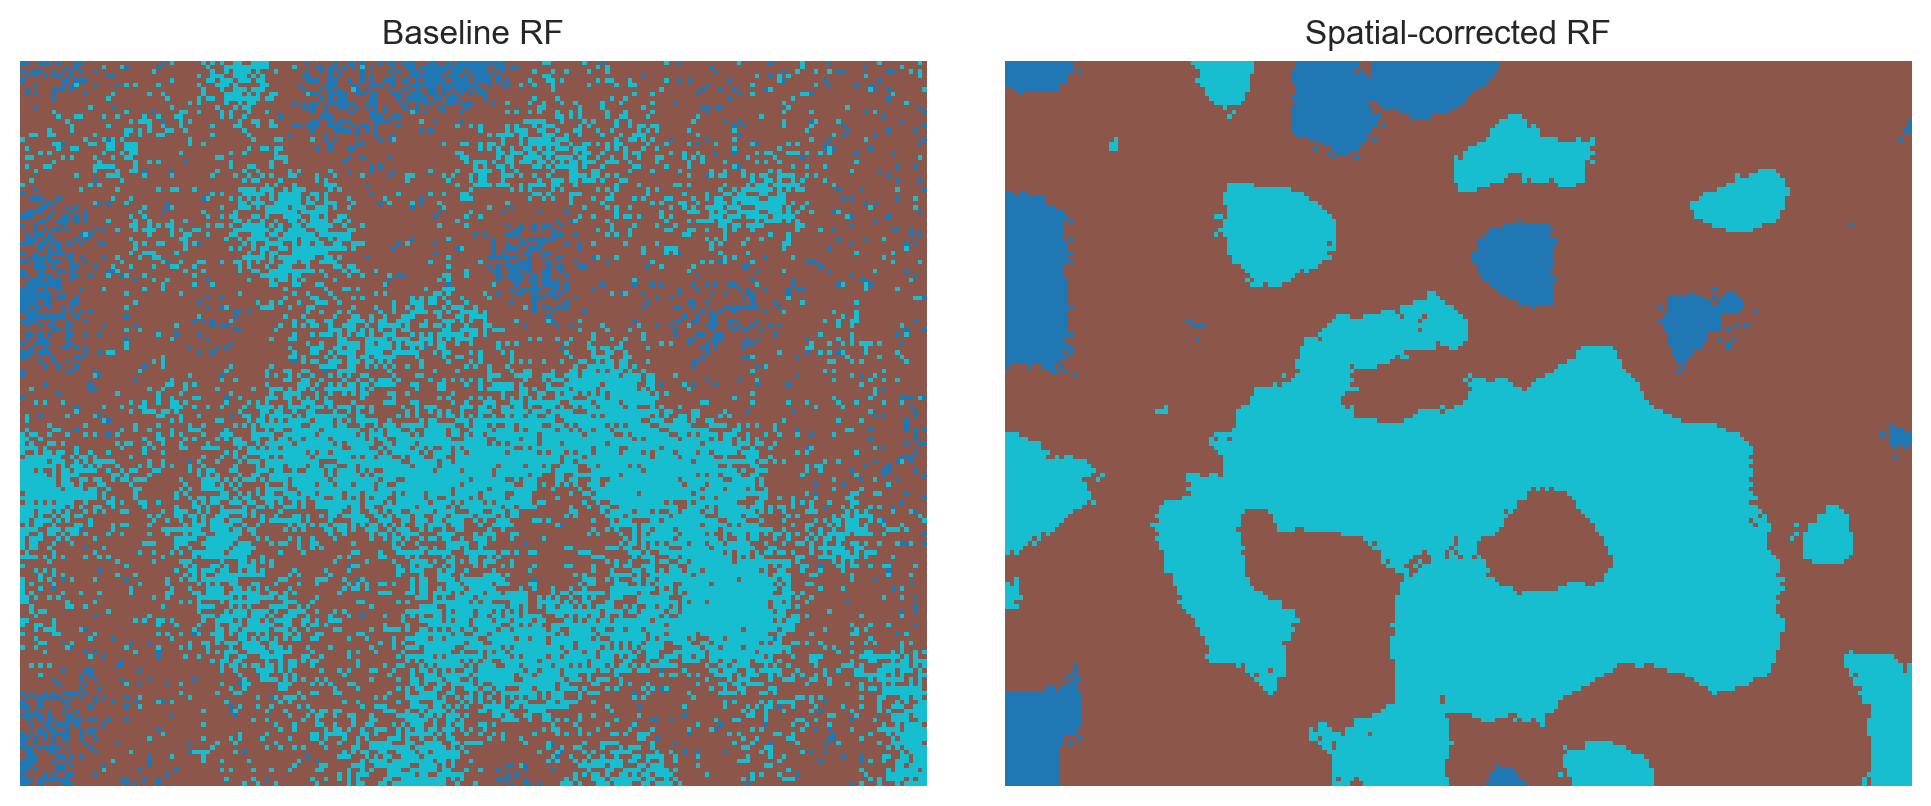

In [6]:
# Add local-mean feature and retrain
local_mean = gaussian_filter(feat_signal, sigma=2.0)
X_spatial = np.stack([feat_signal.ravel(), feat_noise.ravel(), local_mean.ravel()], axis=1)
clf_sp = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)
clf_sp.fit(X_spatial[train_idx], y_full[train_idx])
pred_sp_full = clf_sp.predict(X_spatial).reshape(H, W)
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].imshow(pred_base_full, cmap=cm, vmin=0, vmax=2); axes[0].axis('off'); axes[0].set_title('Baseline RF')
axes[1].imshow(pred_sp_full, cmap=cm, vmin=0, vmax=2); axes[1].axis('off'); axes[1].set_title('Spatial-corrected RF')
plt.tight_layout(); plt.show()

In [7]:
# Metrics: salt-and-pepper & remote-block accuracy
tr0, tr1, tc0, tc1 = 100, 150, 120, 185
test_mask_remote = np.zeros((H, W), dtype=bool)
test_mask_remote[tr0:tr1, tc0:tc1] = True
test_idx_remote = np.flatnonzero(test_mask_remote.ravel())
y_remote = y_full[test_idx_remote]
saltpepper_base = np.mean(pred_base_full != median_filter(pred_base_full, size=3))
saltpepper_sp   = np.mean(pred_sp_full   != median_filter(pred_sp_full,   size=3))
pred_base_remote = clf_base.predict(X_full[test_idx_remote])
pred_sp_remote   = clf_sp.predict(X_spatial[test_idx_remote])
acc_base_remote = accuracy_score(y_remote, pred_base_remote)
acc_sp_remote   = accuracy_score(y_remote, pred_sp_remote)
print(f"Remote accuracy -- baseline: {acc_base_remote:.3f}, spatial-corrected: {acc_sp_remote:.3f}")
print(f"Salt-and-pepper proportion -- baseline: {saltpepper_base:.3f}, spatial-corrected: {saltpepper_sp:.3f}")

Remote accuracy -- baseline: 0.762, spatial-corrected: 0.965
Salt-and-pepper proportion -- baseline: 0.204, spatial-corrected: 0.012


In [8]:
# Blocked CV (raster)
from sklearn.model_selection import GroupKFold
n_block_rows, n_block_cols = 8, 10
row_block_size = H // n_block_rows
col_block_size = W // n_block_cols
block_id = np.zeros((H,W), dtype=int)
bid = 0
for br in range(n_block_rows):
    for bc in range(n_block_cols):
        r0 = br * row_block_size
        c0 = bc * col_block_size
        r1 = (br+1) * row_block_size if br < n_block_rows-1 else H
        c1 = (bc+1) * col_block_size if bc < n_block_cols-1 else W
        block_id[r0:r1, c0:c1] = bid
        bid += 1
blocks_flat = block_id.ravel()
gkf = GroupKFold(n_splits=5)
fold_results = []
for fold, (train_idx_fold, test_idx_fold) in enumerate(gkf.split(X_full, y_full, groups=blocks_flat)):
    clf_b = RandomForestClassifier(n_estimators=100, random_state=fold)
    clf_b.fit(X_full[train_idx_fold], y_full[train_idx_fold])
    pred_test = clf_b.predict(X_full[test_idx_fold])
    acc = accuracy_score(y_full[test_idx_fold], pred_test)
    fold_results.append(acc)
    print(f'Fold {fold}: acc={acc:.3f}')
print('Blocked CV mean acc:', np.mean(fold_results))

Fold 0: acc=0.703
Fold 1: acc=0.712
Fold 2: acc=0.753
Fold 3: acc=0.733
Fold 4: acc=0.727
Blocked CV mean acc: 0.7256562500000001


## Conclusion (basic)
- Baseline RF (no neighborhood) produces speckled errors.
- Simple neighborhood features or small structured postprocessing reduce salt-and-pepper.
- For larger problems, learned embeddings and CRF/MRF-style models are viable; see the Advanced notebook.